In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch
import EDMDTester

nontrain_func = lambda x: torch.cat([torch.ones((x.shape[0], 1)), x], dim=1)
config_file = "paramkoopman1000-10.json"

param_solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)
param_solver.setup(nontrain_func)
param_solver.dictionary.load("data/paramkoopman1000-10_dict.pt")
param_solver.K.load("data/paramkoopman1000-10_koopman.pt")
param_K = param_solver.K

num_param = 10
config_file = "EDMD-RBF.json"
edmd_solver = EDMDTester.EDMDTester(
    config_file,
    num_param,
    nontrain_func,
    param_min=torch.tensor([0.0, -2.0, 0.0]),
    param_max=torch.tensor([1.0, 2.0, 2.0]),
    seed_param=param_solver.seed_param,
    is_edmd=True
)
config_file = "EDMDDL.json"
edmddl_solver = EDMDTester.EDMDTester(
    config_file,
    num_param,
    nontrain_func,
    param_min=torch.tensor([0.0, -2.0, 0.0]),
    param_max=torch.tensor([1.0, 2.0, 2.0]),
    seed_param=param_solver.seed_param,
    is_edmd=False
)

CUDA is available. GPU is being used.


/home/yxqian/code/deep_learning/Para-Koopman-Learning/PKoopmanDL/Dictionary.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._network.load_state_dict(torch.load(pat

## Plot

2024-11-04 20:41:45,576 PKoopmanDL: [INFO] [EDMDSolver] Solving...
2024-11-04 20:41:52,043 PKoopmanDL: [INFO] [EDMDDLSolver] Solving...
Training: 100%|██████████| 10/10 [01:27<00:00,  8.77s/it, train_loss=1.08e-05, val_loss=5.58e-06]


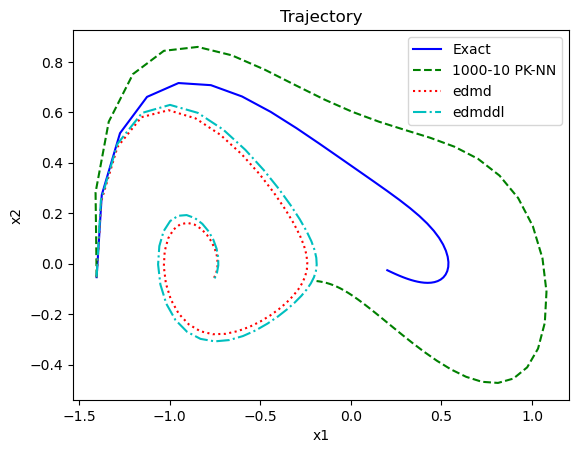

In [ ]:
param = torch.tensor([[0.5, 0.0, 0.5]]).detach()
ode = param_solver.ode
flowmap = param_solver.flowmap
x_min = param_solver.x_min
x_max = param_solver.x_max
traj_len = param_solver.traj_len
dim_nontrain = param_solver.dim_nontrain
state_pos = [1,2]

# Solving via EDMD and EDMDDL
edmd_K, edmd_dictionary = edmd_solver.solve(param)
edmddl_K, edmddl_dictionary = edmddl_solver.solve(param)


dataset_predict = pkdl.ODEDataSet(ode, flowmap)
dataset_predict.generate_data(1, traj_len, x_min, x_max, param)
x_traj = dataset_predict.data_x
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
param_p = param_K.predict(param, x0, param_solver.dictionary, state_pos, traj_len).detach()
param_x_est_traj = param_p[0, :, :]
edmd_p = edmd_K.predict(x0, edmd_dictionary, state_pos, traj_len).detach()
edmd_x_est_traj = edmd_p[0, :, :]
edmddl_p = edmddl_K.predict(x0, edmddl_dictionary, state_pos, traj_len).detach()
edmddl_x_est_traj = edmddl_p[0, :, :]


plt.plot(x_traj[:, 0], x_traj[:, 1], linestyle='-', color='b', label='Exact')
plt.plot(param_x_est_traj[:, 1], param_x_est_traj[:, 2], linestyle='--', color='g', label='1000-10 PK-NN')
plt.plot(edmd_x_est_traj[:, 1], edmd_x_est_traj[:, 2], linestyle=':', color='r', label='edmd')
plt.plot(edmddl_x_est_traj[:, 1], edmddl_x_est_traj[:, 2], linestyle='-.', color='c', label='edmddl')


plt.title('Trajectory')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()